# Figure 3
Create a figure showing 1) scatter plot dEPT/dSO vs. swcf, 2) scatter plot Clim ITCZ vs. swcf, and 3) map of SWCF vs dEPT/dSO

In [2]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plotting Utils

In [6]:
def make_cyclic(ds): 
    ds_end = ds.isel(lon=-1)
    ds_end["lon"] = 180
    ds_beg = ds.isel(lon=0)
    ds_beg["lon"] = -180
    ds_beg
    ds = xr.concat([ds_beg, ds, ds_end], dim="lon")
    return ds

def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)

def fix_coords_no_time(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(0, 360))
    return data

In [8]:
def _global_plot(
    ax, 
    data, 
    lon, 
    lat, 
    cmap, 
    pvalues=None, 
    right_title="", 
    left_title="", 
    levels=np.arange(-4, 4.1, .1), 
    cbar_label: str = "",
    contours=None,
    pr=None,
    wind=None,
):
    # plot map of global data with central longitude 180
    # Uncomment for reds
    # cmap = matplotlib.cm.get_cmap(cmap)
    # norm = matplotlib.colors.Normalize(vmin=np.min(levels), vmax=np.max(levels))
    # cmap = [cmap(norm(l)) for l in levels]
    # cmap[0] = (1, 1, 1, 1) # Set first element to white
    
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        # colors=cmap, # uncomment for reds
        cmap=cmap,
        extend="both",
        levels=levels,
    )
    if contours is not None:
        psl = ax.contour(
            lon, lat, contours,
            transform=ccrs.PlateCarree(),
            colors="black",
            # levels=[-1, -.9, -.8, -.7, -.6, -.5, -.4] # Contours for -1 to 1 correlations
            # levels=[-300, -200, -100, 0, 100, 125, 150, 175, 200] # Contours for PSL
        )

    if pr is not None:
        ax.contour(
            lon, lat, pr,
            transform=ccrs.PlateCarree(),
            colors="magenta",
            levels=[-6, 6],
        )
    
    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
    
    if wind is not None:
        # Scale reg maps 25 
        # q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], scale=150, headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        # Scale for Pr wind maps
        q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        ax.quiverkey(q, .9, -.15, .25, str(.25) + r' $\frac{m}{s}/\sigma$', labelpos='E', transform=ccrs.PlateCarree(), coordinates='axes')
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # # East Pacific South America
    # bound_region(ax, lons=(-105, -70), lats=(-40, -10), color="black")
    # Southern Ocean
    bound_region(ax, lons=(-180, -75), lats=(-70, -50), color="black")
    # Southern ITCZ 
    # bound_region(ax, lons=(-130, -80), lats=(-20, 0), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # add cbar label to top of colorbar
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
    # cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.030, pad=0.02)
    cbar.ax.set_title(cbar_label, fontsize=10)

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )


# Load Data

In [ ]:
DATA_ROOT = "/home/espinosa10/SO-EP-teleconnection/Data"

# dEPT/dSO at variance timescales: CMIP
rvalues_so_ept_coupling = xr.open_dataset(os.path.join(DATA_ROOT, "so_ept_coupling.nc"))
swcf_cmip6 = fix_coords_no_time(xr.open_dataset('/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_cmip6_monthly_1850-2000.nc'))
swcf_cmip5 = fix_coords_no_time(xr.open_dataset('/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_cmip5_monthly_1850-2000.nc'))
swcf_cmip = xr.concat([swcf_cmip6, swcf_cmip5], dim="model")

# Generate point-wise pearson-correlation maps
rvalues_so_ept_coupling, swcf_cmip = get_shared_models(rvalues_so_ept_coupling, swcf_cmip)
r = xscore.pearson_r(rvalues_so_ept_coupling["reg"].sel(years=12*5), swcf_cmip["swcf"], dim="model", skipna=True)
p = xscore.pearson_r_eff_p_value(rvalues_so_ept_coupling["reg"].sel(years=12*5), swcf_cmip["swcf"], dim="model", skipna=True)

r2 = make_cyclic(r**2)
p = make_cyclic(p)

2025-01-28 15:08:57,758 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2025-01-28 15:08:57,821 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core

# Figure 3

Text(0.0, 1.0, '5-year')

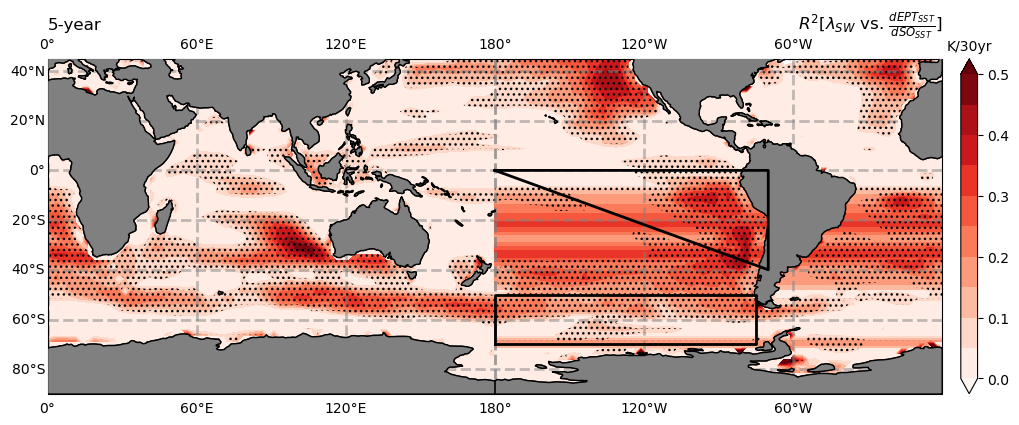

In [10]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r2.values,
    pvalues=p,
    lat=r2.lat,
    lon=r2.lon,
    levels=np.arange(0, .55, .05),
    cmap="Reds",
    cbar_label="K/30yr"
)
ax1.set_title(r"$R^2[\lambda_{SW}$ vs. $\frac{dEPT_{SST}}{dSO_{SST}}]$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)